# Solution Part III

## 0. Basic Steps

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression, ElasticNet, Lasso
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    plot_precision_recall_curve,
    plot_roc_curve
)

In [2]:
df = pd.read_csv('clean_data.csv', index_col='user_id')

In [3]:
X = df.drop('class',axis=1)
y = df['class']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=100, stratify=y)

## 1. First model

In [4]:
cat_cols = X_train.columns[X_train.dtypes=='object'].to_list()

In [5]:
num_cols = [x for x in X_train.columns if x not in cat_cols]

In [6]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
    
    def transform(self, X, *_):
        if isinstance(X, pd.DataFrame):
            return pd.DataFrame(X[self.columns])
    
    def fit(self, X, *_):
        return self


In [7]:
pipe_num = Pipeline(
    [
        ("select", ColumnSelector(num_cols)),
        ("scale", MinMaxScaler())
    ]
)

In [8]:
pipe_cat = Pipeline(
    [
        ("select", ColumnSelector(cat_cols)),
        ("ohe", OneHotEncoder(handle_unknown='ignore'))
    ]
)

In [9]:
union = FeatureUnion(
    [
        ("numeric", pipe_num),
        ("categoric", pipe_cat),
    ]
)

In [10]:
full_pipe = Pipeline(
    [
        ("preprocessing", union),
        ("clf", None)
    ]
)

In [11]:
param_grid = [
#     {
#         "clf": [ElasticNet()], 
#         "clf__alpha": [np.logspace(-3, 2, 7)], 
#         "clf__l1_ratio": [0.2, 0.5, 0.9]
#     },
    {
        "clf": [CatBoostClassifier()],
        "clf__n_estimators": [50, 200, 500],
        "clf__depth": [None, 1, 2, 3]
    }
]

In [12]:
cat = CatBoostClassifier(n_estimators=20, verbose=False)
cat.fit(full_pipe.fit_transform(X_train), y_train)

In [13]:
y_hat_train = cat.predict(full_pipe.transform(X_train))
y_hat_test = cat.predict(full_pipe.transform(X_test))

## Metrics
### Train results

In [14]:
print(classification_report(y_train, y_hat_train))

              precision    recall  f1-score   support

           0       0.93      0.89      0.91       418
           1       0.90      0.94      0.92       481

    accuracy                           0.91       899
   macro avg       0.92      0.91      0.91       899
weighted avg       0.91      0.91      0.91       899



<AxesSubplot:>

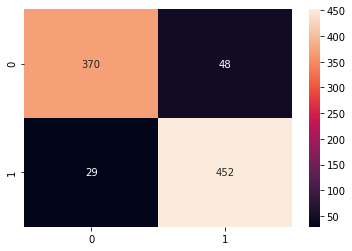

In [15]:
sns.heatmap(confusion_matrix(y_train, y_hat_train), annot=True, fmt='.0f')

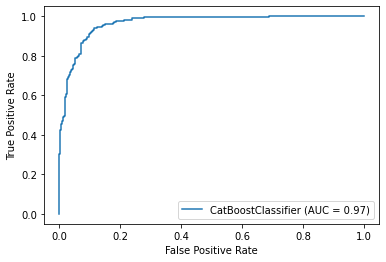

In [16]:
plot_roc_curve(cat, full_pipe.transform(X_train), y_train)

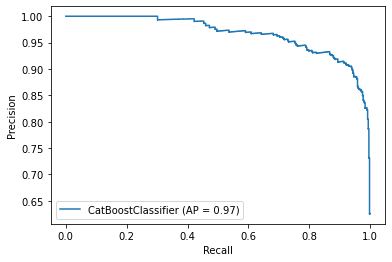

In [17]:
plot_precision_recall_curve(cat, full_pipe.transform(X_train), y_train)

### Test results

In [18]:
print(classification_report(y_test, y_hat_test))

              precision    recall  f1-score   support

           0       0.72      0.67      0.70        46
           1       0.74      0.78      0.76        54

    accuracy                           0.73       100
   macro avg       0.73      0.73      0.73       100
weighted avg       0.73      0.73      0.73       100



<AxesSubplot:>

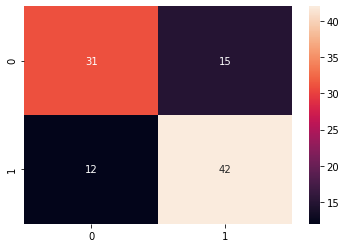

In [19]:
sns.heatmap(confusion_matrix(y_test, y_hat_test), annot=True, fmt='.0f')

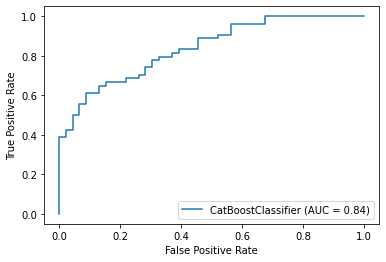

In [20]:
plot_roc_curve(cat, full_pipe.transform(X_test), y_test)

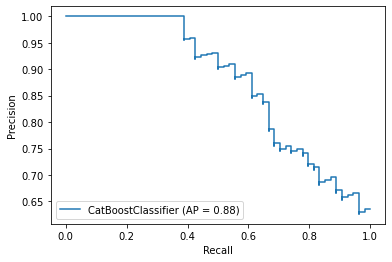

In [21]:
plot_precision_recall_curve(cat, full_pipe.transform(X_test), y_test)

In [22]:
known_cols = [x for x in X_train.columns[:-4]]
cat_cols_names =  [f'cat_{i}' for i in range(len(cat.feature_names_)-len(known_cols))] 

features = pd.Series(cat.feature_importances_, index=known_cols + cat_cols_names).sort_values(ascending=False)

<AxesSubplot:>

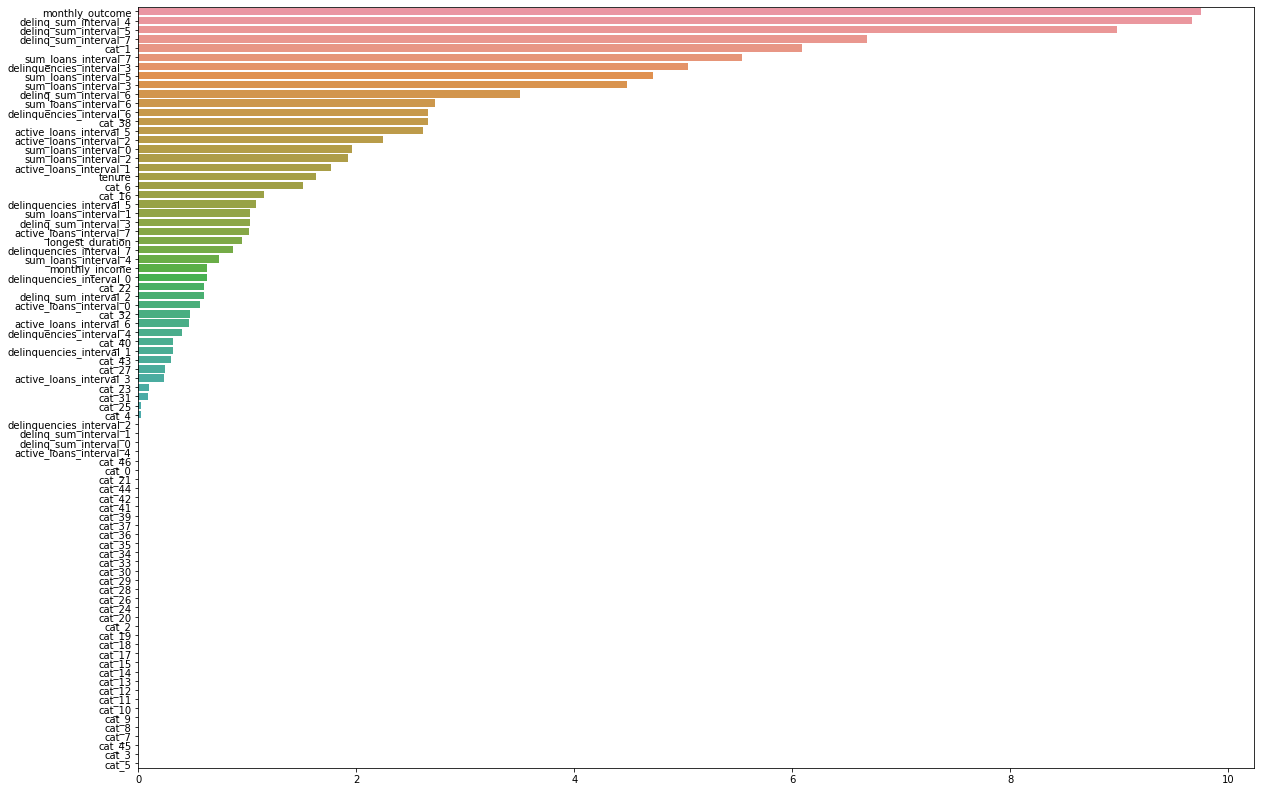

In [23]:
plt.figure(figsize=(20,14))
sns.barplot(x=features.values, y=features.index)

### Thoughts
- I know I shouldn't go for a Gradient Boosting model as my first choice, but I did it due to the time constraints and ease of use.
- The model in question is currently overfitting a bit, but I will still use it for answering the questions asked.
- Most of the categorical features appear to be useless, and the ones that seem to be useful might be due to the previously mentioned overfit.
- Regarding the metrics, I was keeping an eye closely to the precision as well as the f1-score. The first one in order to ensure that the classes are well detected and the second one in order to have an overall good model.

## Deployment
**Meaningless disclaimer:** This is the first time I work with this kind of data and much of the time I spent researching how to define the metrics, interest rates, amounts, etc. That being said, I found this metric on the web, so credits to the author.

You can find the original article here:
https://www.listendata.com/2019/07/KS-Statistics-Python.html

In [24]:
def ks(data=None,target=None, prob=None):
    data['target0'] = 1 - data[target]
    data['bucket'] = pd.qcut(data[prob], 10)
    grouped = data.groupby('bucket', as_index = False)
    kstable = pd.DataFrame()
    kstable['min_prob'] = grouped.min()[prob]
    kstable['max_prob'] = grouped.max()[prob]
    kstable['events']   = grouped.sum()[target]
    kstable['nonevents'] = grouped.sum()['target0']
    kstable = kstable.sort_values(by="min_prob", ascending=False).reset_index(drop = True)
    kstable['event_rate'] = (kstable.events / data[target].sum()).apply('{0:.2%}'.format)
    kstable['nonevent_rate'] = (kstable.nonevents / data['target0'].sum()).apply('{0:.2%}'.format)
    kstable['cum_eventrate']=(kstable.events / data[target].sum()).cumsum()
    kstable['cum_noneventrate']=(kstable.nonevents / data['target0'].sum()).cumsum()
    kstable['KS'] = np.round(kstable['cum_eventrate']-kstable['cum_noneventrate'], 3) * 100

    #Formating
    kstable['cum_eventrate']= kstable['cum_eventrate'].apply('{0:.2%}'.format)
    kstable['cum_noneventrate']= kstable['cum_noneventrate'].apply('{0:.2%}'.format)
    kstable.index = range(1,11)
    kstable.index.rename('Decile', inplace=True)
    pd.set_option('display.max_columns', 9)
    print(kstable)
    
    #Display KS
    from colorama import Fore
    print(Fore.RED + "KS is " + str(max(kstable['KS']))+"%"+ " at decile " + str((kstable.index[kstable['KS']==max(kstable['KS'])][0])))
    return(kstable)

In [25]:
y_proba = pd.DataFrame(cat.predict_proba(full_pipe.transform(X_test)), columns=['bad', 'good'], index=X_test.index)
y_proba = pd.concat([y_proba, y_test], axis=1)

In [26]:
results = ks(y_proba, target='class', prob='good')

        min_prob  max_prob  events  nonevents event_rate nonevent_rate  \
Decile                                                                   
1       0.952477  0.978461      10          0     18.52%         0.00%   
2       0.894902  0.947988      10          0     18.52%         0.00%   
3       0.812251  0.880602       7          3     12.96%         6.52%   
4       0.658374  0.808536       7          3     12.96%         6.52%   
5       0.604616  0.651277       4          6      7.41%        13.04%   
6       0.478268  0.594558       5          5      9.26%        10.87%   
7       0.401178  0.468776       5          5      9.26%        10.87%   
8       0.206115  0.398475       4          6      7.41%        13.04%   
9       0.105279  0.200737       2          8      3.70%        17.39%   
10      0.005684  0.098308       0         10      0.00%        21.74%   

       cum_eventrate cum_noneventrate    KS  
Decile                                       
1             18.52

Given the KS score, we define our model threshold as the `min_prob` for that decile.

In [42]:
min_prob = results.loc[results['KS'].idxmax(), 'min_prob']

In [43]:
y_test_probas = cat.predict_proba(full_pipe.transform(X_test))

And we check out our findings

              precision    recall  f1-score   support

           0       0.67      0.87      0.75        46
           1       0.85      0.63      0.72        54

    accuracy                           0.74       100
   macro avg       0.76      0.75      0.74       100
weighted avg       0.77      0.74      0.74       100



<AxesSubplot:>

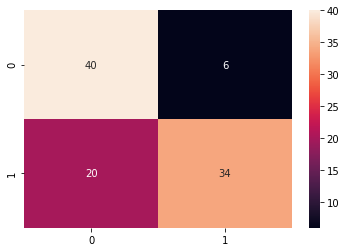

In [44]:
print(classification_report(y_test, (y_test_probas[:,1] >= min_prob).astype(int)))
sns.heatmap(confusion_matrix(y_test, (y_test_probas[:,1] >= min_prob).astype(int)), annot=True, fmt='.0f')

### Best Clients
In this case, I would only lend money to the people that was labeled as 1 by the model, given this threshold. So, essentially 40 Loans from which 6 individuals will not pay off the debt and 34 that will.

From the **test set**, this would be the ones I would choose.

In [54]:
y_test.loc[(y_test_probas[:,1] >= min_prob)].index

Int64Index([444, 933, 221, 519, 780, 565, 847, 868, 556,  17, 909, 139, 227,
            640, 878, 342, 207, 742, 157, 849, 902, 574, 326, 858, 881, 289,
            423, 385, 650, 569, 945, 191, 313, 859, 250, 451, 948, 231, 728,
            214],
           dtype='int64', name='user_id')

### Amount to lend
I'm not entirely sure how much to lend them, but I would lend them as much as I can and as much as they can take it, without defaulting.

In [56]:
best_clients = X_test.loc[(y_test_probas[:,1] >= min_prob)]

In [74]:
amounts = best_clients['monthly_income'] - best_clients['monthly_outcome']
display(amounts.loc[amounts>0])
print()
print(amounts.loc[amounts>0].sum())

user_id
444      56559
519       1026
565    1843234
847      25578
868      75965
556      16503
17        1741
139      51702
878      66624
342     496819
858       3934
881        742
650       6215
945       4397
250      17371
728       6963
dtype: int64


2675373


\$2675373 Would be the maximum they could take.

### Interest Rate

In [75]:
FP, TP = confusion_matrix(y_test, (y_test_probas[:,1] >= min_prob).astype(int))[:,1]

In [76]:
(FP + TP)/TP-1

0.17647058823529416


If I were to lend them 1 dollar each, at the very least the good 34 creditors would have to pay for the entire portfolio. So the minimum Interest Rate would be 17,6%.
At that rate, if the debtors were to take the credits, I would have a minimum of 0% ROI. In this case, any profit I may have will be from the installments that the bad borrowers manage to pay.